In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [2]:
df = web.DataReader('SBUX', data_source='yahoo', start='2012-01-01', end='2020-6-10') 

In [3]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,23.520000,22.639999,23.424999,22.645000,12922400.0,19.675068
2012-01-04,23.315001,22.639999,22.705000,23.084999,13886800.0,20.057360
2012-01-05,23.200001,22.775000,23.094999,23.180000,9731800.0,20.139898
2012-01-06,23.455000,23.115000,23.190001,23.360001,8105400.0,20.296291
2012-01-09,23.400000,23.135000,23.365000,23.295000,7261600.0,20.239815
...,...,...,...,...,...,...
2020-06-04,80.169998,78.470001,79.309998,78.739998,7667600.0,78.739998
2020-06-05,82.330002,79.970001,80.330002,82.139999,12030800.0,82.139999
2020-06-08,83.620003,82.180000,83.080002,83.559998,10229600.0,83.559998


In [4]:
df.shape

(2123, 6)

F:\Python\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


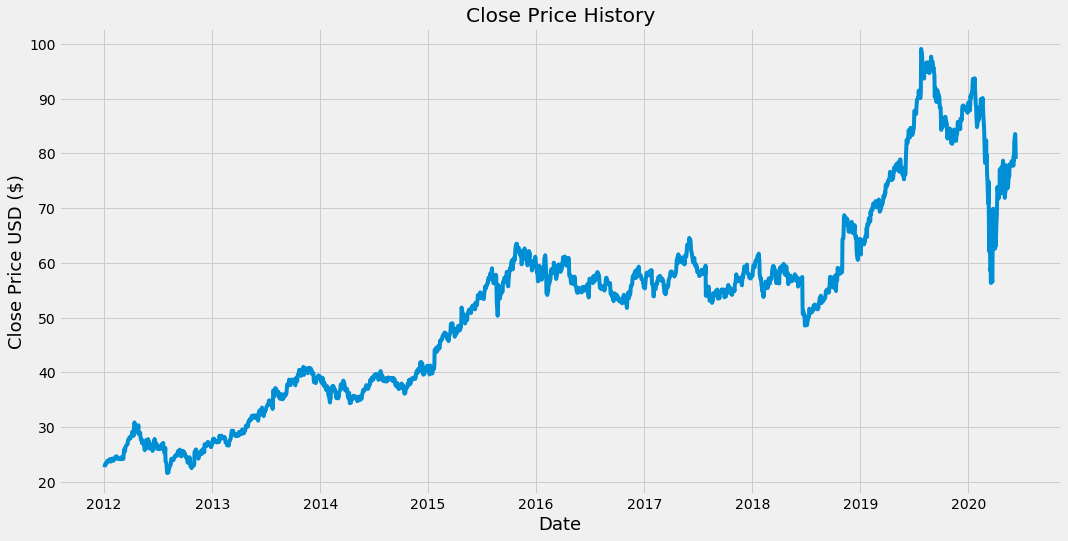

In [5]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [7]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

In [8]:
#Converting the dataframe to a numpy array
dataset = data.values

In [9]:
#Get the Compute number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [10]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [11]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]

In [12]:
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [13]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [14]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [15]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [16]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1639/1639 [==============================] - 100s 61ms/step - loss: 5.8600e-04


In [18]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]

In [20]:
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [21]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [22]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [26]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [25]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

4.238457295052572

In [27]:
#Plot and Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

F:\Python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


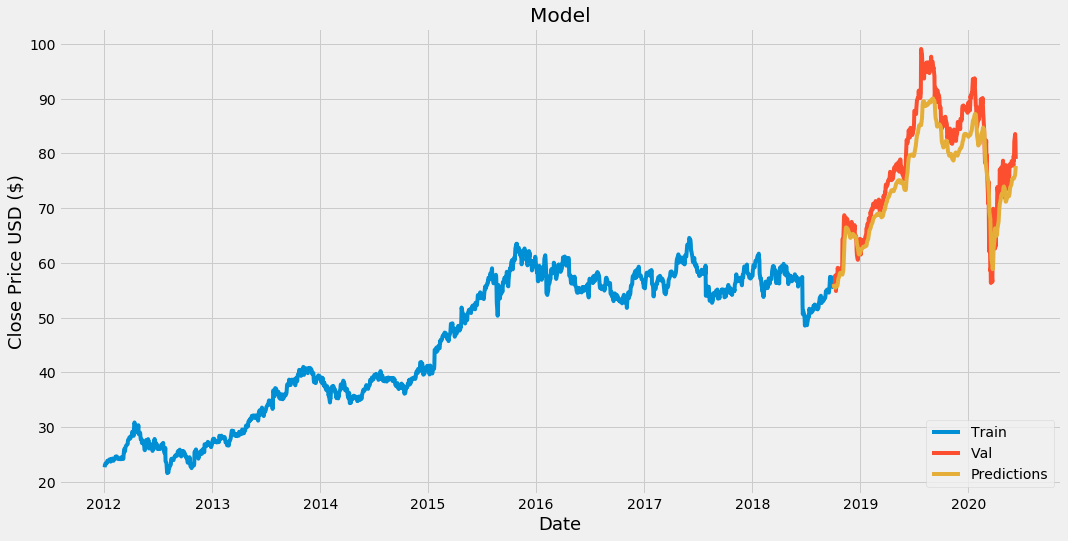

In [28]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [30]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-10-03,55.470001,56.139915
2018-10-04,55.889999,55.842613
2018-10-05,55.759998,55.630718
2018-10-08,56.540001,55.476440
2018-10-09,57.709999,55.488155
...,...,...
2020-06-04,78.739998,75.514435
2020-06-05,82.139999,75.583397
2020-06-08,83.559998,76.126472
